# 07 - Audio
(Largely based on rbracco's tutorial, **big** thanks to him for his work on getting this going for us!)

`fastai`'s audio module has been in development for a while by active forum members:

* [rbracco](https://github.com/rbracco)
* [kevinbird15](https://github.com/kevinbird15)
* [mogwai](https://github.com/mogwai)
* [Hiromis](https://github.com/hiromis)
* [scart97](https://github.com/scart97)
* [hoftherose](https://github.com/hoftherose)
* [madhavajay](https://github.com/madhavajay)
* [Jo](https://github.com/aquietlife/)

# What makes Audio different?

While it is possible to train on raw audio (we simply pass in a 1D tensor of the signal), what is done now is to convert the audio to what is called a **spectrogram** to train on.

![](https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png)

# Installing the `fastai_audio` library:

We'll be installing from their `git` repository, similar to how we did for the dev version of `fastai`

In [ ]:
!pip install git+https://github.com/fastaudio/fastaudio.git

  Cloning https://github.com/fastaudio/fastaudio.git to /tmp/pip-req-build-qbyvllun
  Running command git clone -q https://github.com/fastaudio/fastaudio.git /tmp/pip-req-build-qbyvllun
     |████████████████████████████████| 194kB 4.6MB/s 
     |████████████████████████████████| 6.7MB 9.9MB/s 
     |████████████████████████████████| 184kB 53.8MB/s 
     |████████████████████████████████| 788kB 55.2MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 358kB 59.8MB/s 
  Created wheel for fastaudio: filename=fastaudio-0.0.post0.dev126+g66b6230-py2.py3-none-any.whl size=17840 sha256=01caa3b75c3aab49eb9e983a09336dd2bd19931abc2c4b0a1af5eb3b2142be98
  Stored in directory: /tmp/pip-ephem-wheel-cache-q63rwr60/wheels/20/af/b1/ea2a6d91971f5e3f435c6a0aa2ae8b7a010b644cc01e24b0ce
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=7539329c7e483ae2e9cd85c107e36b4200faa3b8d676bf6ea73df406bffcc2d3
  Stored in directory:

We'll also need `torchaudio`

# Free Digit Dataset

Essentially the audio version of `MNIST`, it contains 2,000 recordings from 10 speakers saying each digit 5 times. First, we'll grab the data and use a custom extract function:

In [ ]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

`tar_extract_at_filename` simply extracts at the file name (as the name suggests)

In [ ]:
path_dig = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

Now we want to grab just the audio files.

In [ ]:
audio_extensions[:5]

('.aif', '.aifc', '.aiff', '.au', '.m3u')

In [ ]:
fnames = get_files(path_dig, extensions=audio_extensions)

In [ ]:
fnames[:5]

(#5) [Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00136.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00326.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00307.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00411.wav'),Path('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00155.wav')]

We can convert any audio file to a tensor with `AudioTensor`. Let's try opening a file:

In [ ]:
at = AudioTensor.create(fnames[0])

In [ ]:
at, at.shape

(AudioTensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0002, -0.0002, -0.0003]]),
 torch.Size([1, 58240]))

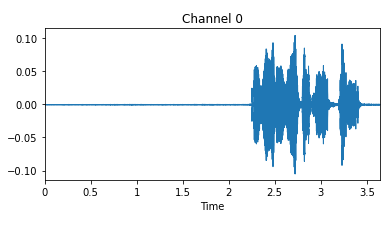

In [ ]:
at.show()

# Preparing the dataset

`fastai_audio` has a `AudioConfig` class which allows us to prepare different settings for our dataset. Currently it has:
* BasicMelSpectrogram
* BasicMFCC
* BasicSpectrogram
* Voice

We'll be using the **Voice** module today, as this dataset just contains human voices.

In [ ]:
cfg = AudioConfig.Voice()

Our configuration will limit options like the frequency range and the sampling rate

In [ ]:
cfg.f_max, cfg.sample_rate

(8000.0, 16000)

We can then make a transform from this configuration to turn raw audio into a workable spectrogram per our settings:

In [ ]:
aud2spec = AudioToSpec.from_cfg(cfg)

For our example, we'll crop out the original audio file to 1000 ms

In [ ]:
crop1s = ResizeSignal(1000)

Let's build a `Pipeline` how we'd expect our data to come in

In [ ]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

And try visualizing what our newly made data becomes.

First, we'll remove that cropping:

In [ ]:
pipe = Pipeline([AudioTensor.create, aud2spec])

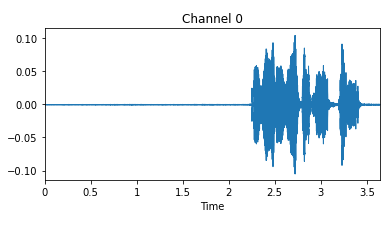

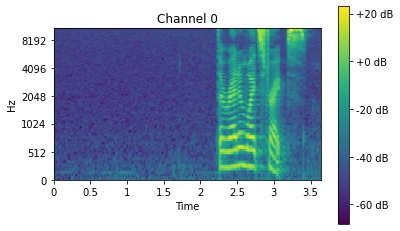

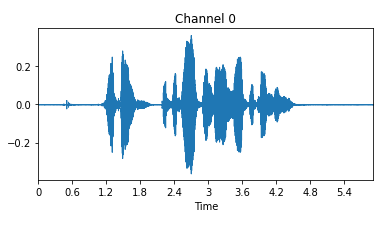

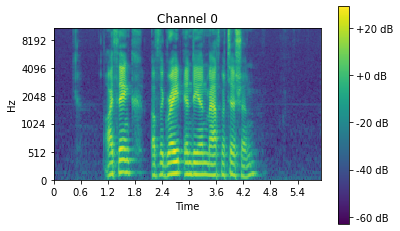

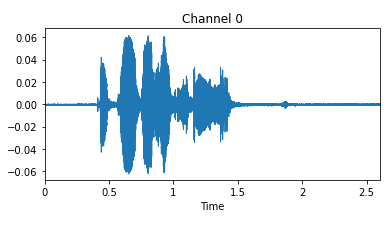

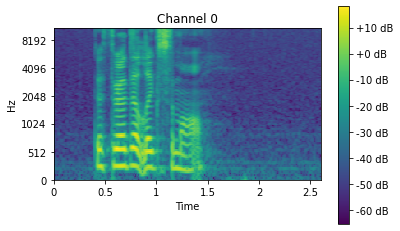

In [ ]:
for fn in fnames[:3]:
  audio = AudioTensor.create(fn)
  audio.show()
  pipe(fn).show()

You can see that they're not all the same size here. Let's add that cropping back in:

In [ ]:
pipe = Pipeline([AudioTensor.create, crop1s, aud2spec])

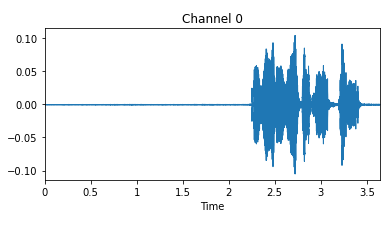

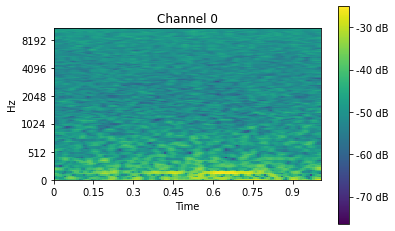

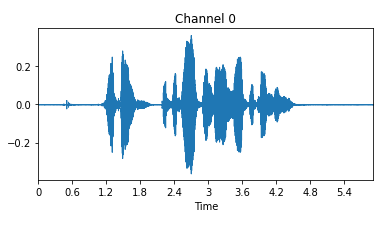

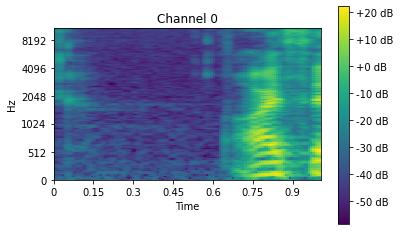

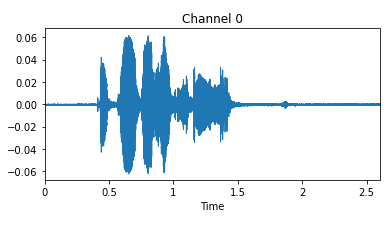

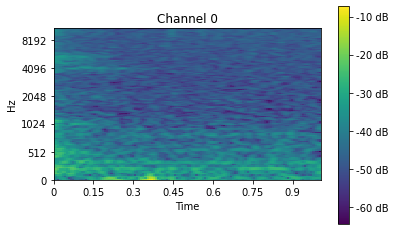

In [ ]:
for fn in fnames[:3]:
  audio = AudioTensor.create(fn)
  audio.show()
  pipe(fn).show()

And now everythign is 128x63

# Using the `DataBlock` API:

* We'll want to use our same transforms we used for the `Pipeline`
* An appropriate `getter`
* An appropriate labeller

For our transforms, we'll want the same ones we used before

In [ ]:
item_tfms = [ResizeSignal(1000), aud2spec]

Our filenames are labelled by the number followed by the name of the individual:
* `4_theo_37.wav`
* `2_nicolas_7.wav`

In [ ]:
get_y = lambda x: x.name[0]

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

And now we can build our `DataLoaders`

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=64)

Let's look at a batch

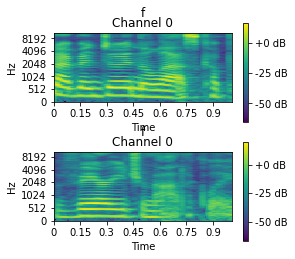

In [ ]:
dls.show_batch(max_n=3)

# Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input (similar to how we did for the Bengali.AI model)

In [ ]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [ ]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

Now we need to grab our number of channels:

In [ ]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [ ]:
alter_learner(learn, n_c)

Now we can find our learning rate and fit!

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0020892962347716093)

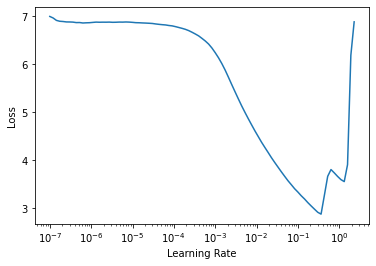

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.052515,0.323332,0.881510,00:11
1,0.401659,0.156771,0.924479,00:11
2,0.210763,0.696115,0.798177,00:11
3,0.119320,0.239732,0.923177,00:11
4,0.063962,0.029512,0.993490,00:11


In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.030099,0.034156,0.986979,00:11
1,0.031116,0.021291,0.996094,00:12
2,0.032417,0.017661,0.997396,00:11
3,0.025745,0.017490,0.994792,00:11
4,0.022410,0.016554,0.997396,00:11


Not bad for zero data augmentation! But let's see if augmentation can help us out here!

# Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [ ]:
aud2spec.settings

{'mel': 'True',
 'to_db': 'False',
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 50.0,
 'f_max': 8000.0,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None,
 'sr': 16000,
 'nchannels': 1}

And we'll narrow this down a bit

In [ ]:
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

Now let's rebuild our `DataBlock`:

In [ ]:
item_tfms = [RemoveSilence(), ResizeSignal(1000), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=get_y)

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

Let's look at some augmented data:

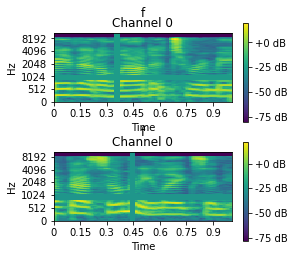

In [ ]:
dls.show_batch(max_n=3)

Let's try training again. Also, since we have to keep making an adustment to our model, let's make an `audio_learner` function similar to `cnn_learner`:

In [ ]:
def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  learn = Learner(dls, arch, loss_func, metrics=metrics)
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: alter_learner(learn)
  return learn

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.002511886414140463)

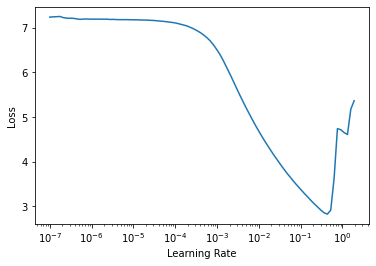

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.650460,1.274344,0.776042,00:17
1,1.882244,0.165905,0.928385,00:17
2,0.958342,0.023563,0.993490,00:17
3,0.537469,0.020922,0.994792,00:17
4,0.317845,0.012210,0.996094,00:17
5,0.193368,0.030548,0.990885,00:17
6,0.118598,0.014498,0.996094,00:17
7,0.074519,0.002216,1.000000,00:17
8,0.047171,0.003482,1.000000,00:17
9,0.030317,0.002047,1.000000,00:17


In [ ]:
learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.003665,0.003438,1.000000,00:17
1,0.004991,0.003278,1.000000,00:17
2,0.005746,0.017678,0.997396,00:17
3,0.005073,0.002702,0.998698,00:17
4,0.003955,0.002549,1.000000,00:17
5,0.003551,0.001628,1.000000,00:17
6,0.003751,0.001688,1.000000,00:17
7,0.003312,0.003636,0.998698,00:17
8,0.003430,0.003046,1.000000,00:17
9,0.003002,0.002288,1.000000,00:17


With the help of some of our data augmentation, we were able to perform a bit higher!

# Mel Frequency Cepstral Coefficient (MFCC)

Now let's look at that MFCC option we said earlier. MFCC's are a "linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency" - Wikipedia. But what does that mean?

![](https://www.researchgate.net/publication/335398843/figure/fig1/AS:796124961058818@1566822390492/MFCC-mel-frequency-cepstral-coefficients-characteristic-vectors-extraction-flow.png)

Let's try it out!

In [ ]:
aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,
                                             'n_mels':128})

In [ ]:
item_tfms = [ResizeSignal(1000), aud2mfcc]

There's a shortcut for replacing the item transforms in a `DataBlock`:

In [ ]:
aud_digit.item_tfms

(#8) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ,Resample:
encodes: (AudioTensor,object) -> encodes
decodes: ,DownmixMono:
encodes: (AudioTensor,object) -> encodes
decodes: ,RemoveSilence:
encodes: (AudioTensor,object) -> encodes
decodes: ,ResizeSignal:
encodes: (AudioTensor,object) -> encodes
decodes: ,AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: ,MaskTime:
encodes: (AudioSpectrogram,object) -> encodes
decodes: ,MaskFreq:
encodes: (AudioSpectrogram,object) -> encodes
decodes: ]

In [ ]:
aud_digit.item_tfms = item_tfms

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

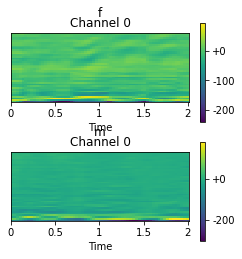

In [ ]:
dls.show_batch(max_n=3)

Now let's build our learner and train again!

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0020892962347716093)

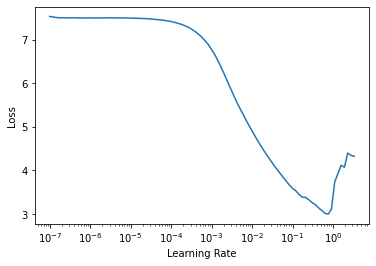

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.969720,1.324741,0.812500,00:09
1,0.805437,0.774530,0.738281,00:09
2,0.427395,0.071427,0.970052,00:09
3,0.251631,0.052916,0.980469,00:09
4,0.156765,0.026019,0.989583,00:09


Now we can begin to see why choosing your augmentation is important!

# MFCC + Delta:

The last transform we'll discuss is the `Delta` transform:

> Local estimate of the derivative of the input data along the selected axis.

This allows multiple-channeled inputs from one signal

In [ ]:
item_tfms = [ResizeSignal(1000), aud2mfcc, Delta()]

In [ ]:
aud_digit.item_tfms = item_tfms

In [ ]:
dls = aud_digit.dataloaders(path_dig, bs=128)

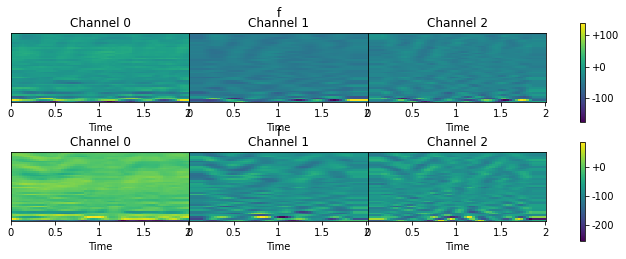

In [ ]:
dls.show_batch(max_n=3)

Let's try training one more time:

In [ ]:
learn = audio_learner(dls, xresnet18(), CrossEntropyLossFlat(), accuracy)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0014454397605732083)

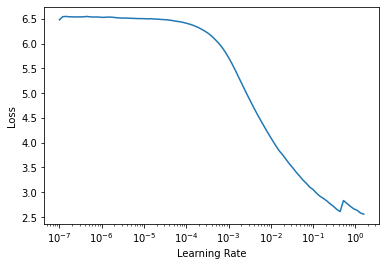

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.581891,0.626583,0.882812,00:13
1,0.678377,0.197535,0.912760,00:13
2,0.367090,0.094837,0.962240,00:13
3,0.220476,0.022505,0.992188,00:13
4,0.141336,0.033642,0.988281,00:13


Let's try fitting for a few more:

In [ ]:
learn.fit_one_cycle(5, 1e-2/10)

epoch,train_loss,valid_loss,accuracy,time
0,0.029490,0.022874,0.993490,00:13
1,0.027482,0.022706,0.992188,00:13
2,0.025360,0.015615,0.994792,00:13
3,0.026397,0.026350,0.990885,00:13
4,0.027179,0.022311,0.993490,00:13
